# Data Cleaning and Manipulation

In [1]:
import pandas as pd
import datetime as dt
import fasttext
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

In [31]:
# read csv files
biden_df = pd.read_csv(r"C:\Users\User\iCloudDrive\Cursos\Data Circle\DataCircle_Twitter_Project\hashtag_joebiden.csv",lineterminator='\n')
trump_df = pd.read_csv(r"C:\Users\User\iCloudDrive\Cursos\Data Circle\DataCircle_Twitter_Project\hashtag_donaldtrump.csv", lineterminator='\n')

print(biden_df.info())
print(trump_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 776886 entries, 0 to 776885
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   created_at            776886 non-null  object 
 1   tweet_id              776886 non-null  float64
 2   tweet                 776886 non-null  object 
 3   likes                 776886 non-null  float64
 4   retweet_count         776886 non-null  float64
 5   source                776173 non-null  object 
 6   user_id               776886 non-null  float64
 7   user_name             776861 non-null  object 
 8   user_screen_name      776886 non-null  object 
 9   user_description      694877 non-null  object 
 10  user_join_date        776886 non-null  object 
 11  user_followers_count  776886 non-null  float64
 12  user_location         543092 non-null  object 
 13  lat                   355293 non-null  float64
 14  long                  355293 non-null  float64
 15  

## Data Preprocessing

In [32]:
# create a new column 'candidate' to differentiate tweets of each candidate after concatenation 
trump_df['candidate'] = 'trump'

# biden dataframe 
biden_df['candidate'] = 'biden'

# combining the dataframes 
twitter_df = pd.concat([trump_df, biden_df])


In [4]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1747805 entries, 0 to 776885
Data columns (total 22 columns):
 #   Column                Dtype  
---  ------                -----  
 0   created_at            object 
 1   tweet_id              float64
 2   tweet                 object 
 3   likes                 float64
 4   retweet_count         float64
 5   source                object 
 6   user_id               float64
 7   user_name             object 
 8   user_screen_name      object 
 9   user_description      object 
 10  user_join_date        object 
 11  user_followers_count  float64
 12  user_location         object 
 13  lat                   float64
 14  long                  float64
 15  city                  object 
 16  country               object 
 17  continent             object 
 18  state                 object 
 19  state_code            object 
 20  collected_at          object 
 21  candidate             object 
dtypes: float64(7), object(15)
memory usage: 306.7+ M

### Remove irrelevant data

In [33]:
# Remove irrelevant data ("user_name", "user_screen_name", "user_description")
twitter_df = twitter_df[['created_at', 'tweet_id', 'tweet', 'likes', 'retweet_count', 'source',
       'user_id', 'user_join_date', 'user_followers_count', 'user_location', 'lat',
       'long', 'city', 'country', 'continent', 'state', 'state_code',
       'collected_at', 'candidate']]

### Ensure data consistency

In [34]:
# Standardize timestamps to a consistent timezone (UTC).
def standardize_timezone(df, timestamp_column, current_timezone='UTC'):
    # Convert the timestamp column to datetime, handling errors
    df[timestamp_column] = pd.to_datetime(df[timestamp_column], errors='coerce')

    # Check if the column is timezone-naive and localize if needed
    if df[timestamp_column].dt.tz is None or df[timestamp_column].dt.tz_localize(None).notnull().all():
        df[timestamp_column] = df[timestamp_column].dt.tz_localize(current_timezone, ambiguous='NaT', nonexistent='shift_forward')
    
    # Convert to the target timezone (UTC) for both timezone-aware and localized columns
    df[timestamp_column] = df[timestamp_column].dt.tz_convert('UTC')

     # Round the timestamps to the nearest second
    df[timestamp_column] = df[timestamp_column].dt.round('s')

    return df


twitter_df = standardize_timezone(twitter_df, 'created_at', current_timezone='America/New_York')
twitter_df = standardize_timezone(twitter_df, 'user_join_date', current_timezone='America/New_York')
twitter_df = standardize_timezone(twitter_df, 'collected_at', current_timezone='America/New_York')

In [35]:
# Function to convert selected columns to int
def convert_columns_to_int(df, columns):
    for column in columns:
        # Convert to numeric first to handle any non-numeric values
        df[column] = pd.to_numeric(df[column], errors='coerce').fillna(0).astype('int64') 
    return df

columns_to_convert_int = ['likes', 'retweet_count', 'user_followers_count', 'tweet_id', 'user_id']
twitter_df = convert_columns_to_int(twitter_df, columns_to_convert_int)

In [36]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1747805 entries, 0 to 776885
Data columns (total 19 columns):
 #   Column                Dtype              
---  ------                -----              
 0   created_at            datetime64[ns, UTC]
 1   tweet_id              int64              
 2   tweet                 object             
 3   likes                 int64              
 4   retweet_count         int64              
 5   source                object             
 6   user_id               int64              
 7   user_join_date        datetime64[ns, UTC]
 8   user_followers_count  int64              
 9   user_location         object             
 10  lat                   float64            
 11  long                  float64            
 12  city                  object             
 13  country               object             
 14  continent             object             
 15  state                 object             
 16  state_code            object             


In [37]:
# Ensure all text fields are lowercase for consistent NLP analysis.
def clean_and_convert_text_fields(df, text_columns, tweet_column):
    # Clean and convert text columns to lowercase
    for column in text_columns:
        df[column] = df[column].str.lower().str.strip()  # Convert to lowercase, remove leading and trailing spaces
    
    # Remove URLs from tweet column
    url_pattern = r'http[s]?://\S+|www\.\S+'
    df[tweet_column] = df[tweet_column].str.replace(url_pattern, '', regex=True)

    # Remove unwanted symbols from tweet column
    df[tweet_column] = df[tweet_column].str.replace(r'[^a-zA-Z0-9# ]', '', regex=True)

    return df

# Return the names of object columns
text_columns_to_convert = twitter_df.select_dtypes(include=['object']).columns.tolist()
twitter_df = clean_and_convert_text_fields(twitter_df, text_columns_to_convert, "tweet")

In [38]:
# Load the FastText pre-trained language identification model
model = fasttext.load_model('lid.176.bin')

# Function to detect language
def detect_language(text):
    try:
        predictions = model.predict(text, k=1)  # Get top 1 language prediction
        lang_code = predictions[0][0].split("__label__")[1]  # Extract language code
        return lang_code
    except Exception as e:
        return 'unknown'  # Return 'unknown' for any errors

# Apply language detection to your "tweet" column 
twitter_df['language'] = twitter_df['tweet'].apply(detect_language)

In [39]:
twitter_df['language'].value_counts()

language
en     1321235
es      106995
fr       78032
de       63166
it       50869
        ...   
arz          1
hsb          1
tk           1
bh           1
ne           1
Name: count, Length: 127, dtype: int64

In [40]:
twitter_df[twitter_df['language']=='en']

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_join_date,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at,candidate,language
2,2020-10-15 04:00:02+00:00,1316529228091846912,#trump as a student i used to hear for years f...,2,1,twitter web app,8436472,2007-08-26 09:56:11+00:00,1185,portland,45.520247,-122.674195,portland,united states of america,north america,oregon,or,NaT,trump,en
3,2020-10-15 04:00:02+00:00,1316529227471237120,2 hours since last tweet from #trump maybe he ...,0,0,trumpytweeter,828355589206056960,2017-02-06 02:32:17+00:00,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,trump,en
4,2020-10-15 04:00:08+00:00,1316529252301451264,you get a tie and you get a tie #trump s rally...,4,3,twitter for iphone,47413798,2009-06-15 23:05:35+00:00,5393,washington dc,38.894992,-77.036558,washington,united states of america,north america,district of columbia,dc,NaT,trump,en
5,2020-10-15 04:00:17+00:00,1316529291052675072,clady62 her 15 minutes were over long time ago...,2,0,twitter for android,1138416104,2013-02-01 06:37:38+00:00,2363,"perris,california",33.782519,-117.228648,NaN,united states of america,north america,california,ca,NaT,trump,en
6,2020-10-15 04:00:17+00:00,1316529289949569024,richardmarx glad u got out of the house dick#t...,0,0,twitter for iphone,767401841030209536,2016-08-21 20:43:51+00:00,75,"powell, tn",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,trump,en
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776876,2020-11-09 04:59:16+00:00,1325588732318265088,mr #biden tear down that wall with #mexicowhat...,1,0,twitter for iphone,377229570,2011-09-21 11:13:23+00:00,444,"auckland, nz",-36.852095,174.763180,auckland,new zealand,oceania,auckland,auk,NaT,biden,en
776877,2020-11-09 04:59:32+00:00,1325588800005935104,nyt #beratalbayraks departure may also signal ...,3,0,twitter for iphone,26463075,2009-03-25 13:34:47+00:00,14770,london/ istanbul/izmir /beirut,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,biden,en
776878,2020-11-09 04:59:33+00:00,1325588804141506560,staceyabrams thank you for all your support an...,2,1,twitter for android,225224865,2010-12-11 06:23:21+00:00,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,biden,en
776880,2020-11-09 04:59:37+00:00,1325588821308821504,hypocrite#biden #covid19,2,0,twitter web app,958368465160691584,2018-01-30 20:57:02+00:00,541,venus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,biden,en


In [41]:
# filter only twitter in english language
twitter_df = twitter_df[twitter_df['language']=='en']

In [42]:
# Drop language column
twitter_df = twitter_df.drop(columns='language')

### Handle Outliers

In [43]:
twitter_df.describe()


,tweet_id,likes,retweet_count,user_id,user_followers_count,lat,long
count,1.321235e+06,1.321235e+06,1.321235e+06,1.321235e+06,1.321235e+06,628968.000000,628968.000000
mean,1.322379e+18,7.359144e+00,1.667172e+00,4.568471e+17,1.829023e+04,36.045343,-46.617811
std,2.644676e+15,3.161991e+02,7.832080e+01,5.578748e+17,3.118836e+05,16.857111,70.222158
min,1.316529e+18,0.000000e+00,0.000000e+00,5.310000e+02,0.000000e+00,-90.000000,-175.202642
25%,1.320043e+18,0.000000e+00,0.000000e+00,2.140500e+08,6.500000e+01,32.776272,-100.445882
50%,1.323420e+18,0.000000e+00,0.000000e+00,2.465333e+09,3.760000e+02,39.783730,-77.036558
75%,1.324617e+18,1.000000e+00,0.000000e+00,1.090674e+18,1.830000e+03,43.484913,0.721036
max,1.325589e+18,1.657020e+05,6.347300e+04,1.325581e+18,8.241710e+07,90.000000,179.048837


In [44]:
print("likes skewness:")
print(twitter_df["likes"].skew())
print("\n")
print("likes kurtosis:")
print(twitter_df["likes"].kurtosis())
print("\n")
print("retweet skewness:")
print(twitter_df["retweet_count"].skew())
print("\n")
print("retweet kurtosis:")
print(twitter_df["retweet_count"].kurtosis())

likes skewness:
300.3648486116918


likes kurtosis:
122723.67358647757


retweet skewness:
477.3809564614741


retweet kurtosis:
341694.40636017855


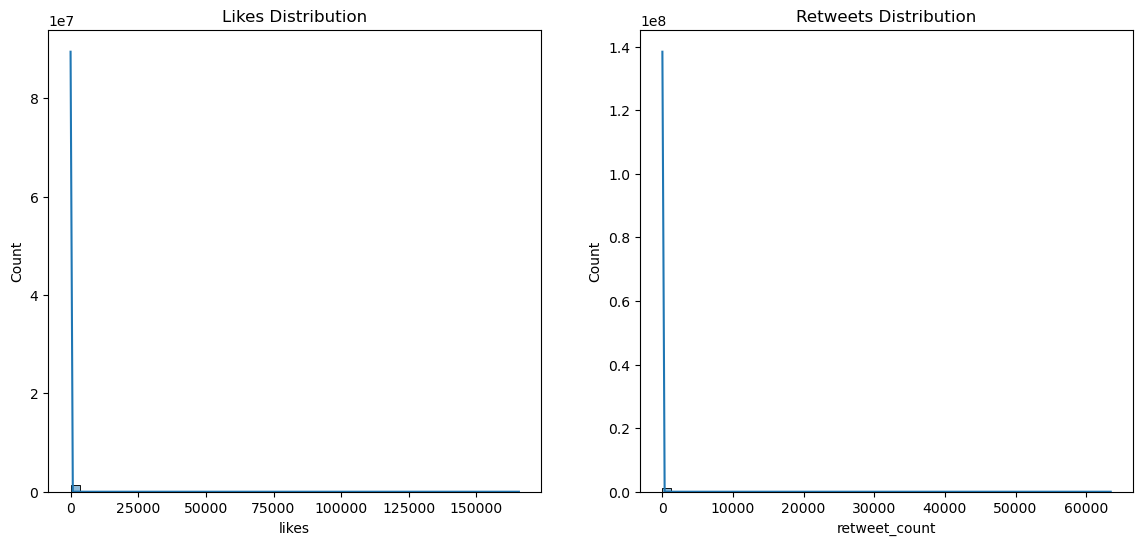

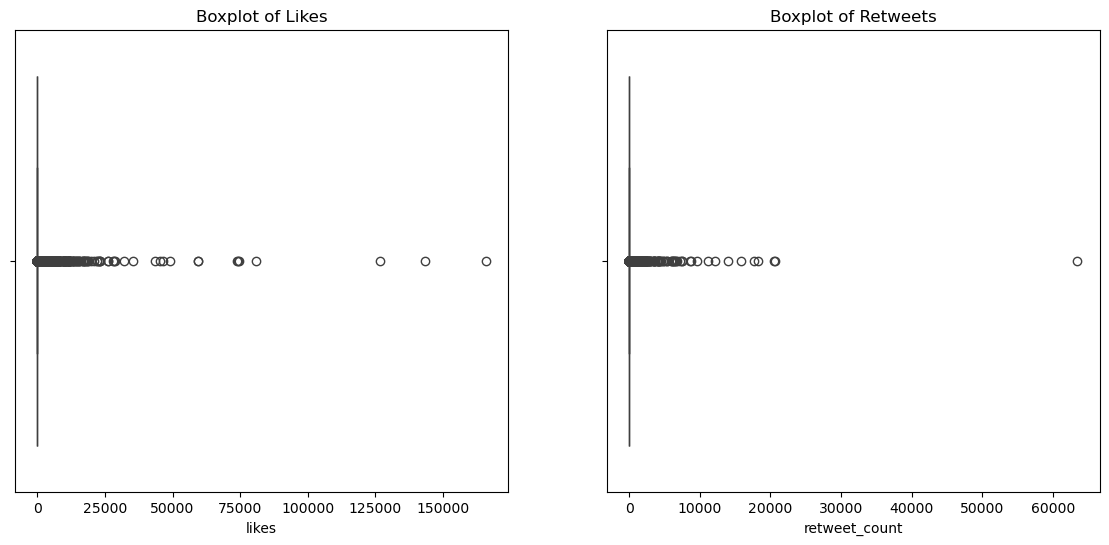

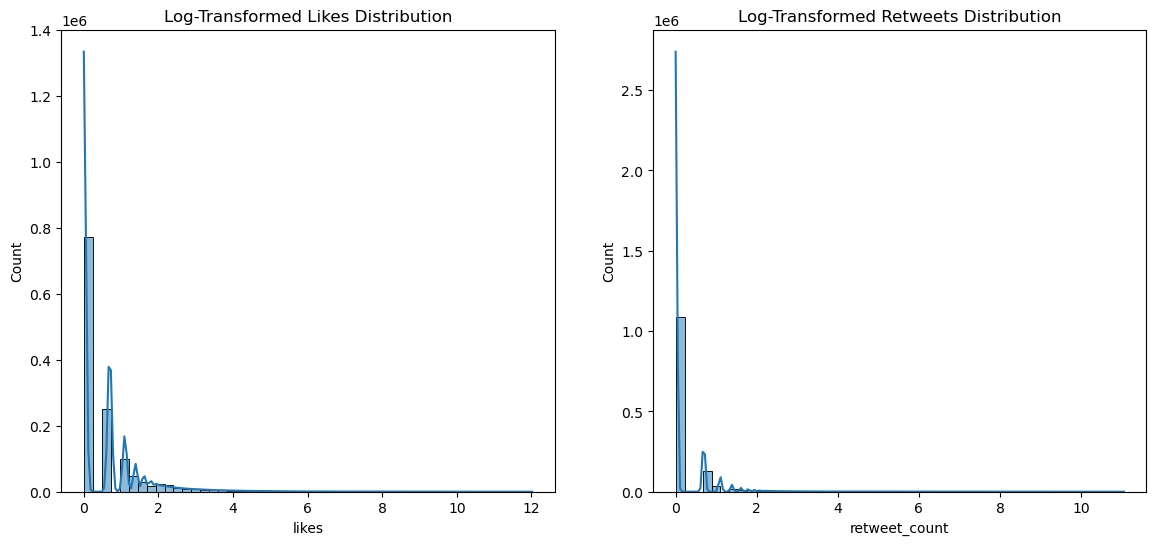

In [45]:
# Subset the data for 'likes' and 'retweets'
likes = twitter_df['likes']
retweets = twitter_df['retweet_count']

# 1. Histogram and KDE for 'likes' and 'retweets'
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(likes, bins=50, kde=True)
plt.title('Likes Distribution')

plt.subplot(1, 2, 2)
sns.histplot(retweets, bins=50, kde=True)
plt.title('Retweets Distribution')

plt.show()

# 2. Boxplot for 'likes' and 'retweets' (helps identify outliers)
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x=likes)
plt.title('Boxplot of Likes')

plt.subplot(1, 2, 2)
sns.boxplot(x=retweets)
plt.title('Boxplot of Retweets')

plt.show()

# 3. Log-transformed histograms to compress extreme outliers
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(np.log1p(likes), bins=50, kde=True)
plt.title('Log-Transformed Likes Distribution')

plt.subplot(1, 2, 2)
sns.histplot(np.log1p(retweets), bins=50, kde=True)
plt.title('Log-Transformed Retweets Distribution')

plt.show()

In [21]:
# Detect outliers using Modified Z-Score for 'likes' and 'retweets'

# For 'likes'
median_likes = twitter_df['likes'].median()
MAD_likes = np.median(np.abs(twitter_df['likes'] - median_likes))
twitter_df['modified_zscore_likes'] = 0.6745 * (twitter_df['likes'] - median_likes) / MAD_likes

# For 'retweets'
median_retweets = twitter_df['retweet_count'].median()
MAD_retweets = np.median(np.abs(twitter_df['retweet_count'] - median_retweets))
twitter_df['modified_zscore_retweets'] = 0.6745 * (twitter_df['retweet_count'] - median_retweets) / MAD_retweets

# Identify outliers with Modified Z-Score > 3.5
outliers_likes_modz = twitter_df[twitter_df['modified_zscore_likes'].abs() > 3.5]
outliers_retweets_modz = twitter_df[twitter_df['modified_zscore_retweets'].abs() > 3.5]

print(f"Number of outliers in 'likes' using Modified Z-Score: {len(outliers_likes_modz)}")
print(f"Number of outliers in 'retweets' using Modified Z-Score: {len(outliers_retweets_modz)}")


Number of outliers in 'likes' using Modified Z-Score: 550162
Number of outliers in 'retweets' using Modified Z-Score: 235174


In [22]:
# Sort outliers based on z scores method by "likes" in ascending order
outliers_likes_modz.sort_values(by="likes", ascending=True)

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_join_date,user_followers_count,user_location,...,long,city,country,continent,state,state_code,collected_at,candidate,modified_zscore_likes,modified_zscore_retweets
897364,2020-11-08 02:16:39+00:00,1325185419676246016,#mueyesseryldzaoezguerluek joe biden #torbayas...,1,1,twitter web app,801008374234173440,2016-11-22 15:24:13+00:00,562,"antalya, türkiye",...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,trump,inf,inf
620632,2020-11-04 22:04:44+00:00,1324034859795361792,#trump is confused alright for once its by the...,1,0,twitter for iphone,1360475474,2013-04-18 02:17:41+00:00,399,from michigan & great britian,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,trump,inf,NaN
620637,2020-11-04 22:04:45+00:00,1324034861557026816,a thoughtprovoking look at the geographical ro...,1,0,twitter web app,30332694,2009-04-11 02:46:27+00:00,395,"new york, ny",...,-74.006015,new york,united states of america,north america,new york,ny,NaT,trump,inf,NaN
266683,2020-11-01 02:55:05+00:00,1322673477925637888,pro#trump hearse chases #biden campaign bus th...,1,0,twitter web app,104362261,2010-01-13 08:15:31+00:00,1814,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,biden,inf,NaN
620643,2020-11-04 22:04:47+00:00,1324034871736430592,realdonaldtrump there is nothing unique illeg...,1,0,twitter web app,2952829165,2014-12-31 05:20:24+00:00,521,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,trump,inf,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536374,2020-11-06 21:31:06+00:00,1324751170511032320,america assembledjoebiden kamalaharris baracko...,74528,20615,twitter for iphone,38362690,2009-05-07 07:55:16+00:00,8080,"brooklyn, ny",...,-73.949583,new york,united states of america,north america,new york,ny,NaT,biden,inf,inf
278831,2020-11-01 23:08:59+00:00,1322963864024174592,thats a pic of me in pennsylvania when i lived...,80670,7553,twitter for iphone,14230524,2008-03-27 02:37:48+00:00,82396325,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,biden,inf,inf
298112,2020-11-02 20:25:15+00:00,1323285046816624640,good morning pennsylvania im so excited to see...,126772,14024,twitter for iphone,14230524,2008-03-27 02:37:48+00:00,82417077,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,biden,inf,inf
10623,2020-10-15 21:09:02+00:00,1316788185481965568,the cowards at twitter locked me out for expos...,143454,63473,twitter for iphone,78523300,2009-09-30 09:31:28+00:00,2685154,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,biden,inf,inf


In [23]:
# Sort outliers based on z scores method by "retweet_count" in ascending order
outliers_retweets_modz.sort_values(by="retweet_count", ascending=True)

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_join_date,user_followers_count,user_location,...,long,city,country,continent,state,state_code,collected_at,candidate,modified_zscore_likes,modified_zscore_retweets
2,2020-10-15 04:00:02+00:00,1316529228091846912,#trump as a student i used to hear for years f...,2,1,twitter web app,8436472,2007-08-26 09:56:11+00:00,1185,portland,...,-122.674195,portland,united states of america,north america,oregon,or,NaT,trump,inf,inf
27363,2020-10-16 20:15:10+00:00,1317137018045030400,#joebiden #donaldtrump #election2020,2,1,hootsuite inc.,3057178511,2015-02-24 02:01:58+00:00,1614,united states,...,-100.445882,NaN,united states,north america,NaN,NaN,NaT,biden,inf,inf
27364,2020-10-16 20:15:10+00:00,1317137017860509696,slikerlea jonkarl realdonaldtrump viewers saw ...,0,1,twitter web app,186467957,2010-09-03 19:00:59+00:00,1676,"los angeles, ca",...,-118.242766,los angeles,united states of america,north america,california,ca,NaT,biden,NaN,inf
27376,2020-10-16 20:16:44+00:00,1317137411416166400,#trump seethed at followup questions in town h...,3,1,twitter web app,16892534,2008-10-21 23:52:32+00:00,35033,somewhere in y'all-land,...,-12.287075,NaN,sierra leone,africa,tonkolili district,NaN,NaT,biden,inf,inf
27385,2020-10-16 20:17:33+00:00,1317137615594921984,donaldjtrumpjr would #biden really raise taxes...,0,1,twitter web app,343956175,2011-07-28 14:07:32+00:00,2754,edinburgh ~ heart of scotland!,...,-3.188375,city of edinburgh,united kingdom,europe,scotland,sct,NaT,biden,NaN,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20432,2020-10-16 07:17:29+00:00,1316941303603728384,tonight a woman in the audience of trumps town...,165702,17652,twitter web app,139823781,2010-05-04 00:00:36+00:00,2028360,"new york, ny",...,-74.006015,new york,united states of america,north america,new york,ny,NaT,biden,inf,inf
164946,2020-10-25 02:34:26+00:00,1320131565335187712,finally #joebiden is absolutely right about so...,46313,18272,twitter for iphone,78523300,2009-09-30 09:31:28+00:00,2694017,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,biden,inf,inf
786530,2020-11-06 21:31:06+00:00,1324751170511032320,america assembledjoebiden kamalaharris baracko...,74084,20491,twitter for iphone,38362690,2009-05-07 07:55:16+00:00,8033,"brooklyn, ny",...,-73.949583,new york,united states of america,north america,new york,ny,NaT,trump,inf,inf
536374,2020-11-06 21:31:06+00:00,1324751170511032320,america assembledjoebiden kamalaharris baracko...,74528,20615,twitter for iphone,38362690,2009-05-07 07:55:16+00:00,8080,"brooklyn, ny",...,-73.949583,new york,united states of america,north america,new york,ny,NaT,biden,inf,inf


In [25]:
print(outliers_likes_modz["likes"].describe())
print("\n")
print(outliers_retweets_modz["retweet_count"].describe())

count    550162.000000
mean         17.673265
std         489.824661
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max      165702.000000
Name: likes, dtype: float64


count    235174.000000
mean          9.366367
std         185.446400
min           1.000000
25%           1.000000
50%           1.000000
75%           3.000000
max       63473.000000
Name: retweet_count, dtype: float64


In [26]:
# Detect outliers using IQR for 'likes' and 'retweets'

# For 'likes'
Q1_likes = twitter_df['likes'].quantile(0.25)
Q3_likes = twitter_df['likes'].quantile(0.75)
IQR_likes = Q3_likes - Q1_likes

lower_bound_likes = Q1_likes - 3 * IQR_likes
upper_bound_likes = Q3_likes + 3 * IQR_likes

# For 'retweets'
Q1_retweets = twitter_df['retweet_count'].quantile(0.25)
Q3_retweets = twitter_df['retweet_count'].quantile(0.75)
IQR_retweets = Q3_retweets - Q1_retweets

lower_bound_retweets = Q1_retweets - 3 * IQR_retweets
upper_bound_retweets = Q3_retweets + 3 * IQR_retweets

# Identify outliers in 'likes' and 'retweets'
outliers_likes = twitter_df[(twitter_df['likes'] < lower_bound_likes) | (twitter_df['likes'] > upper_bound_likes)]
outliers_retweets = twitter_df[(twitter_df['retweet_count'] < lower_bound_retweets) | (twitter_df['retweet_count'] > upper_bound_retweets)]

print(f"Number of outliers in 'likes' using IQR: {len(outliers_likes)}")
print(f"Number of outliers in 'retweets' using IQR: {len(outliers_retweets)}")


Number of outliers in 'likes' using IQR: 122834
Number of outliers in 'retweets' using IQR: 235174


In [27]:
print(outliers_likes["likes"].describe())
print("\n")
print(outliers_retweets["retweet_count"].describe())

count    122834.000000
mean         73.372381
std        1034.710387
min           5.000000
25%           6.000000
50%          11.000000
75%          26.000000
max      165702.000000
Name: likes, dtype: float64


count    235174.000000
mean          9.366367
std         185.446400
min           1.000000
25%           1.000000
50%           1.000000
75%           3.000000
max       63473.000000
Name: retweet_count, dtype: float64


Observations:

Likes:
* The number of outliers decreased after using the 3x IQR factor, which means the bound have been tightened and fewer low outliers have been excluded .
* The mean, median, and standard deviation suggest that many of the outliers are still relatively small, but there are a few extreme values (as indicated by the high max of 165,702).

Retweets:
* The retweet outliers remain unchanged with the 3x IQR factor, indicating that the distribution of retweets may not be as heavily skewed at the lower end. 
* The presence of very low outliers (min = 1) suggests that many entries are being flagged due to the distribution's natural skew.

In [28]:
def cap_outliers(df, columns, lower_quantile=0.05, upper_quantile=0.95):
    """
    Caps outliers in specified columns of a DataFrame based on given quantiles.

    Parameters:
    - df: pandas DataFrame containing the data
    - columns: list of str, the names of the columns to cap outliers in
    - lower_quantile: float, the lower quantile to use for capping (default is 0.05)
    - upper_quantile: float, the upper quantile to use for capping (default is 0.95)

    Returns:
    - DataFrame with additional columns for capped values
    """
    for column in columns:
        # Calculate the upper and lower limits
        upper_limit = df[column].quantile(upper_quantile)
        lower_limit = df[column].quantile(lower_quantile)

        # Create a new column for capped values
        capped_column_name = f"{column}_capped"
        df.loc[:,capped_column_name] = df[column].clip(lower=lower_limit, upper=upper_limit)

    return df

# Applying function:
columns_to_cap = ['likes', 'retweet_count']
twitter_df = cap_outliers(twitter_df, columns_to_cap)

In [30]:
twitter_df.head()

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_join_date,user_followers_count,user_location,...,country,continent,state,state_code,collected_at,candidate,modified_zscore_likes,modified_zscore_retweets,likes_capped,retweet_count_capped
2,2020-10-15 04:00:02+00:00,1316529228091846912,#trump as a student i used to hear for years f...,2,1,twitter web app,8436472,2007-08-26 09:56:11+00:00,1185,portland,...,united states of america,north america,oregon,or,NaT,trump,inf,inf,2,1
3,2020-10-15 04:00:02+00:00,1316529227471237120,2 hours since last tweet from #trump maybe he ...,0,0,trumpytweeter,828355589206056960,2017-02-06 02:32:17+00:00,32,NaN,...,NaN,NaN,NaN,NaN,NaT,trump,NaN,NaN,0,0
4,2020-10-15 04:00:08+00:00,1316529252301451264,you get a tie and you get a tie #trump s rally...,4,3,twitter for iphone,47413798,2009-06-15 23:05:35+00:00,5393,washington dc,...,united states of america,north america,district of columbia,dc,NaT,trump,inf,inf,4,3
5,2020-10-15 04:00:17+00:00,1316529291052675072,clady62 her 15 minutes were over long time ago...,2,0,twitter for android,1138416104,2013-02-01 06:37:38+00:00,2363,"perris,california",...,united states of america,north america,california,ca,NaT,trump,inf,NaN,2,0
6,2020-10-15 04:00:17+00:00,1316529289949569024,richardmarx glad u got out of the house dick#t...,0,0,twitter for iphone,767401841030209536,2016-08-21 20:43:51+00:00,75,"powell, tn",...,NaN,NaN,NaN,NaN,NaT,trump,NaN,NaN,0,0


In [29]:
twitter_df[["likes", "likes_capped", "retweet_count", "retweet_count_capped"]].describe()

,likes,likes_capped,retweet_count,retweet_count_capped
count,1.321235e+06,1.321235e+06,1.321235e+06,1.321235e+06
mean,7.359144e+00,1.317458e+00,1.667172e+00,3.071384e-01
std,3.161991e+02,2.518645e+00,7.832080e+01,7.558768e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
max,1.657020e+05,1.000000e+01,6.347300e+04,3.000000e+00


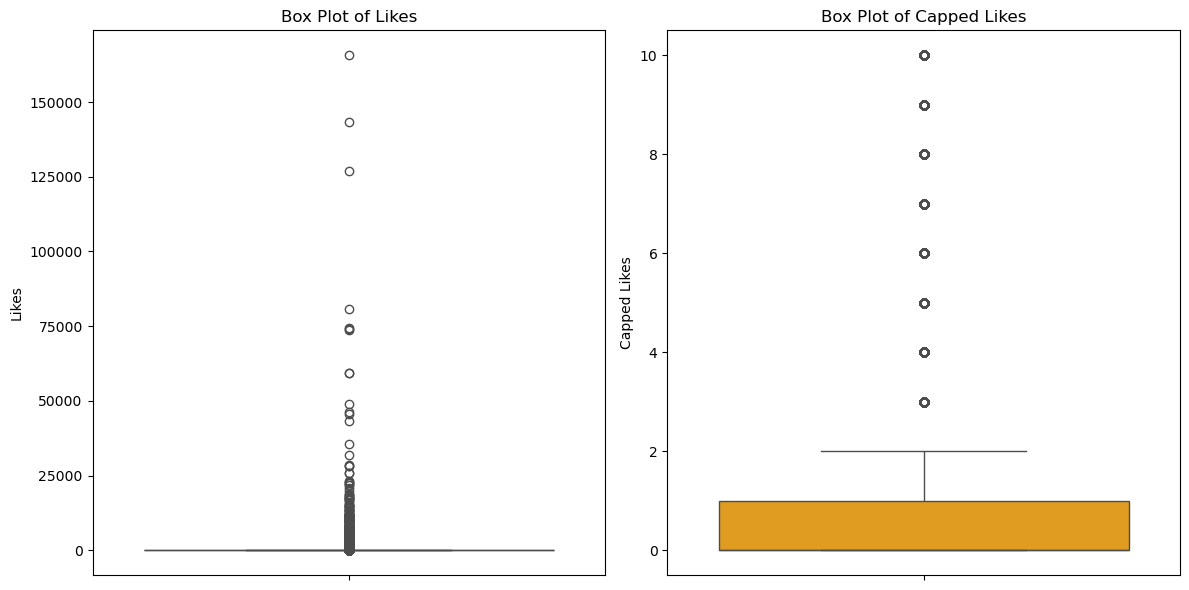

In [61]:
plt.figure(figsize=(12, 6))

# Box plot for original likes
plt.subplot(1, 2, 1)
sns.boxplot(y=twitter_df['likes'], color='blue')
plt.title('Box Plot of Likes')
plt.ylabel('Likes')

# Box plot for capped likes
plt.subplot(1, 2, 2)
sns.boxplot(y=twitter_df['likes_capped'], color='orange')
plt.title('Box Plot of Capped Likes')
plt.ylabel('Capped Likes')

plt.tight_layout()
plt.show()


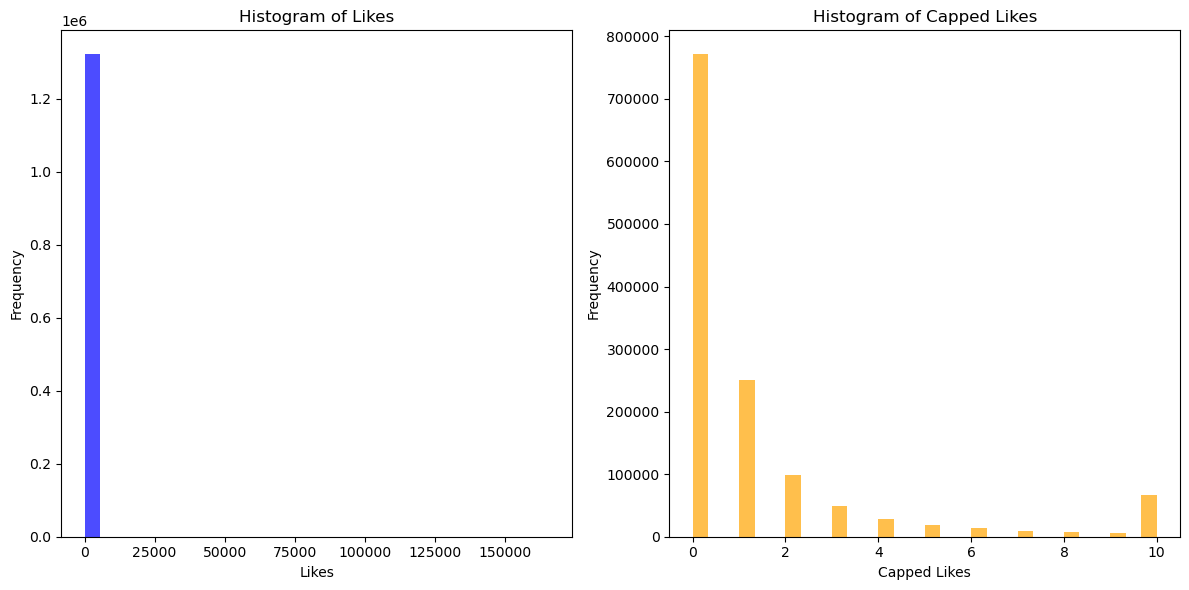

In [62]:
plt.figure(figsize=(12, 6))

# Histogram for original likes
plt.subplot(1, 2, 1)
plt.hist(twitter_df['likes'], bins=30, color='blue', alpha=0.7)
plt.title('Histogram of Likes')
plt.xlabel('Likes')
plt.ylabel('Frequency')

# Histogram for capped likes
plt.subplot(1, 2, 2)
plt.hist(twitter_df['likes_capped'], bins=30, color='orange', alpha=0.7)
plt.title('Histogram of Capped Likes')
plt.xlabel('Capped Likes')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


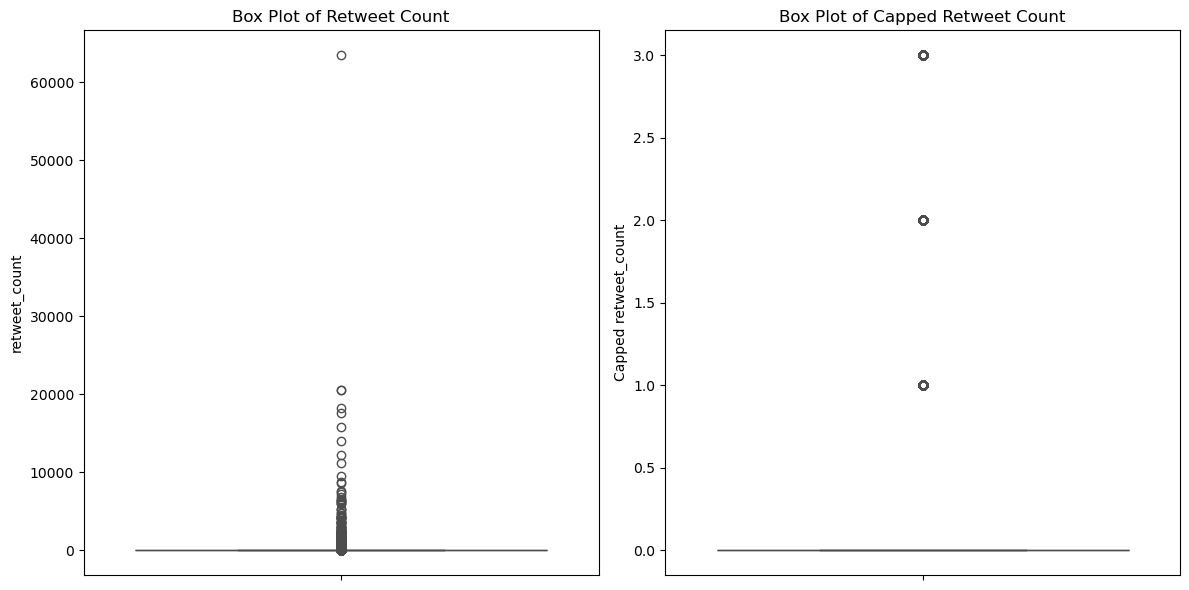

In [63]:
plt.figure(figsize=(12, 6))

# Box plot for original retweet_count
plt.subplot(1, 2, 1)
sns.boxplot(y=twitter_df['retweet_count'], color='blue')
plt.title('Box Plot of Retweet Count')
plt.ylabel('retweet_count')

# Box plot for capped retweet_count
plt.subplot(1, 2, 2)
sns.boxplot(y=twitter_df['retweet_count_capped'], color='orange')
plt.title('Box Plot of Capped Retweet Count')
plt.ylabel('Capped retweet_count')

plt.tight_layout()
plt.show()

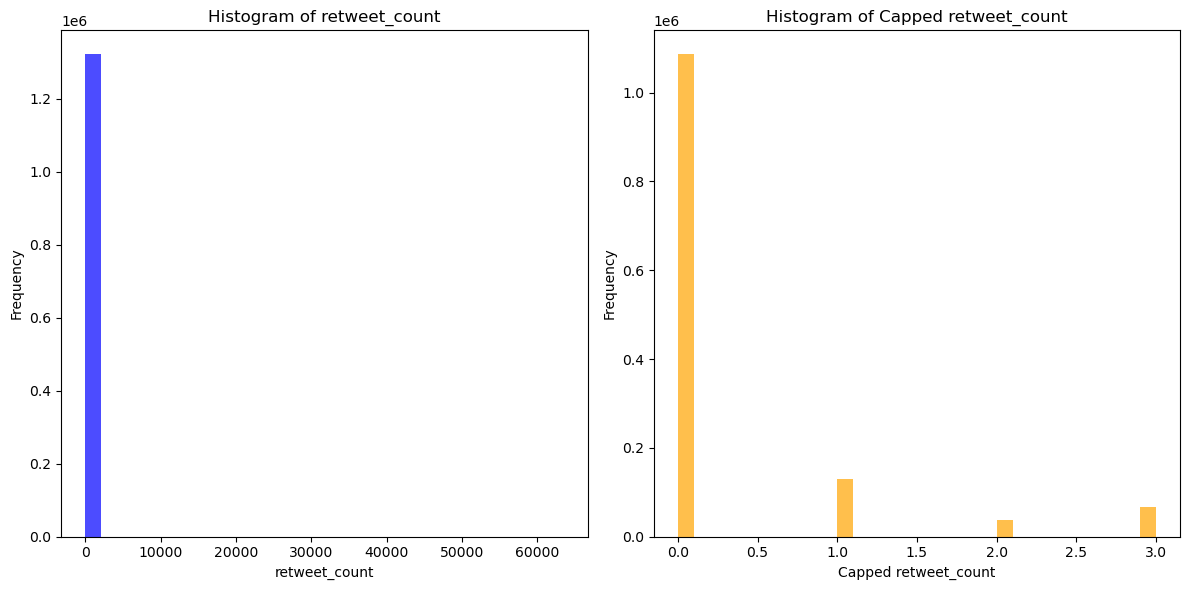

In [64]:
plt.figure(figsize=(12, 6))

# Histogram for original retweet_count
plt.subplot(1, 2, 1)
plt.hist(twitter_df['retweet_count'], bins=30, color='blue', alpha=0.7)
plt.title('Histogram of retweet_count')
plt.xlabel('retweet_count')
plt.ylabel('Frequency')

# Histogram for capped retweet_count
plt.subplot(1, 2, 2)
plt.hist(twitter_df['retweet_count_capped'], bins=30, color='orange', alpha=0.7)
plt.title('Histogram of Capped retweet_count')
plt.xlabel('Capped retweet_count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [87]:
print("capped likes skewness:")
print(twitter_df["likes_capped"].skew())
print("\n")
print("capped likes kurtosis:")
print(twitter_df["likes_capped"].kurtosis())
print("\n")
print("capped retweet skewness:")
print(twitter_df["retweet_count_capped"].skew())
print("\n")
print("capped retweet kurtosis:")
print(twitter_df["retweet_count_capped"].kurtosis())

capped likes skewness:
2.469518567938919


capped likes kurtosis:
5.3155187067948315


capped retweet skewness:
2.6121977626655632


capped retweet kurtosis:
5.894063214349943
